<a href="https://colab.research.google.com/github/ravitata/tflite/blob/main/hand_gesture/hand_gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.4.1
GPU name: 


In [58]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# If you would like to make further imports from Tensorflow, add them here
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

import tensorflow_datasets as tfds

In [59]:
from tensorflow.keras.applications import MobileNetV2

model_mobile = MobileNetV2()
model_mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [61]:
layer_output = model_mobile.get_layer('global_average_pooling2d_2').output

In [62]:
layer_output.shape

TensorShape([None, 1280])

In [63]:
layer_inputs = model_mobile.inputs

In [64]:
layer_inputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>]

In [65]:
new_model = Model(inputs = layer_inputs, outputs = layer_output)
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [66]:
def add_new_classifier_head(feature_extractor_model):
    """
    This function takes the feature extractor model as an argument, and should create
    and return a new model according to the above specification.
    """
    model = Sequential([
                        new_model,
                        Dense(32, activation='relu'),
                        Dropout(rate=0.5),
                        Dense(4, activation='softmax')
    ])
    
    return model

In [67]:
my_model = add_new_classifier_head(new_model)
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 2,299,108
Trainable params: 2,264,996
Non-trainable params: 34,112
_________________________________________________________________


In [192]:
my_model.layers[0].trainable = False
opt = RMSprop(learning_rate=0.001)
my_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])


```
# This is formatted as code

flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
  
```



In [69]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [70]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

3670


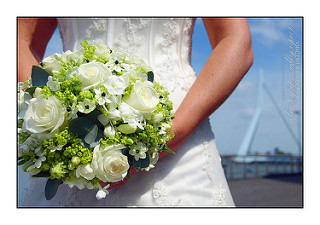

In [71]:
import PIL
import PIL.Image

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

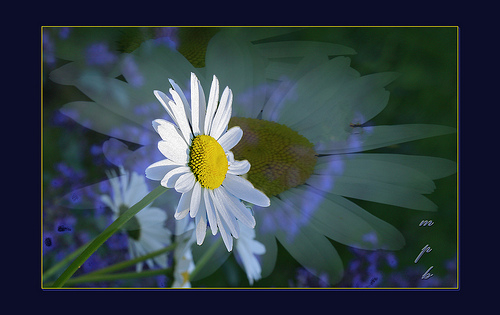

In [72]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

##Setup

In [73]:
import glob
train_path = '/content/drive/MyDrive/Colab Notebooks/data/hand_gestures'
train_list = glob.glob(train_path)

In [75]:
train_list

['/content/drive/MyDrive/Colab Notebooks/data/hand_gestures']

In [76]:
data_dir = pathlib.Path(train_list[0])

In [81]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

68


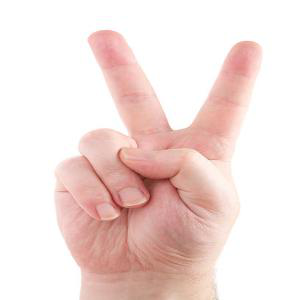

In [77]:
peace = list(data_dir.glob('peace/*.jpg'))
PIL.Image.open(str(peace[0]))

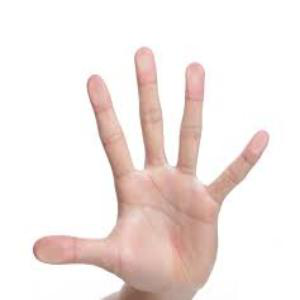

In [78]:
hand = list(data_dir.glob('hand/*.jpg'))
PIL.Image.open(str(hand[1]))

##Using tf.data for finer control

In [168]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [169]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/Colab Notebooks/data/hand_gestures/peace/peace0015.jpg'
b'/content/drive/MyDrive/Colab Notebooks/data/hand_gestures/hand/hand0006.jpg'
b'/content/drive/MyDrive/Colab Notebooks/data/hand_gestures/hand/hand0016.jpg'
b'/content/drive/MyDrive/Colab Notebooks/data/hand_gestures/hand/hand0002.jpg'
b'/content/drive/MyDrive/Colab Notebooks/data/hand_gestures/peace/peace0013.jpg'


In [170]:
#The tree structure of the files can be used to compile a class_names list.
class_names=np.array(sorted([item.name for item in data_dir.glob('*')]))
type(class_names)
print(class_names)

['hand' 'peace' 'thumbs_down' 'thumbs_up']


In [171]:
#Split the dataset into train and validation:

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(len(train_ds))
print(len(val_ds))

55
13


In [172]:
#2nd way and better way
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

55
13


In [173]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.SkipDataset

##Write a short function that converts a file path to an (img, label) pair

In [174]:
batch_size = 8
img_height = 224
img_width = 224

In [176]:
def get_label(file_path):
  #convert the path to the list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  #class name (i.e lable) is 2nd from the right
  one_hot = parts[-2] == class_names
  #Integer encode the label
  #return tf.argmax(one_hot)
  return one_hot


In [177]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  #resize the image to the required size
  return tf.image.resize(img, [img_height, img_width])

In [178]:
def process_path(file_path):
  label = get_label(file_path)
  #read the raw image data
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [179]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [180]:
for i, l in train_ds.take(5):
  print('image shape= ', i.numpy().shape)
  #print('label= ', l.numpy(), ' - ', class_names[l.numpy()])
  print('label= ', l.numpy(), ' - ', class_names[tf.argmax(l.numpy())])

image shape=  (224, 224, 3)
label=  [False  True False False]  -  peace
image shape=  (224, 224, 3)
label=  [ True False False False]  -  hand
image shape=  (224, 224, 3)
label=  [False  True False False]  -  peace
image shape=  (224, 224, 3)
label=  [ True False False False]  -  hand
image shape=  (224, 224, 3)
label=  [False  True False False]  -  peace


In [181]:
#Configure dataset for performance

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.shuffle(100)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [182]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

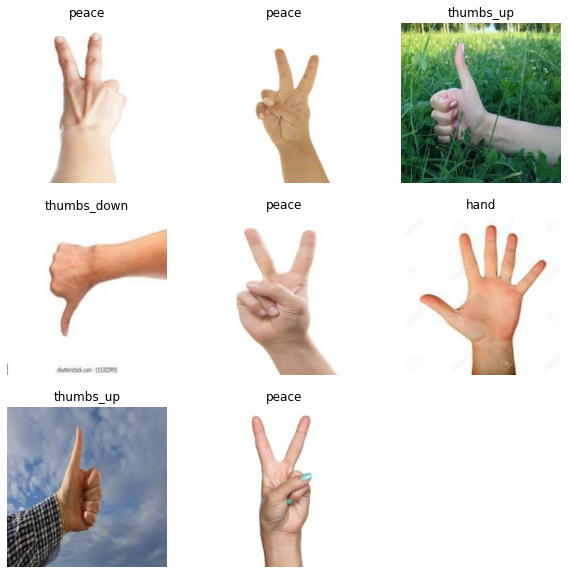

In [210]:
#Visualize the data

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(batch_size):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  #label = class_names[label_batch[i]]
  label = class_names[tf.argmax(label_batch[i])]
  plt.title(label)
  plt.axis('off')

In [202]:
print(image_batch.shape)
print(label_batch.shape)

(7, 224, 224, 3)
(7, 4)


In [194]:
#train the model

history = my_model.fit(train_ds, epochs = 10, validation_data= val_ds)

Epoch 1/10
7/7 [==============================] - 3s 404ms/step - loss: 1.1177 - accuracy: 0.4909 - val_loss: 1.1075 - val_accuracy: 0.5385
Epoch 2/10
7/7 [==============================] - 3s 390ms/step - loss: 1.0331 - accuracy: 0.5636 - val_loss: 1.0089 - val_accuracy: 0.6154
Epoch 3/10
7/7 [==============================] - 3s 396ms/step - loss: 0.8659 - accuracy: 0.7091 - val_loss: 0.8887 - val_accuracy: 0.7692
Epoch 4/10
7/7 [==============================] - 3s 394ms/step - loss: 0.9033 - accuracy: 0.7273 - val_loss: 0.8307 - val_accuracy: 0.6923
Epoch 5/10
7/7 [==============================] - 3s 399ms/step - loss: 0.8676 - accuracy: 0.5818 - val_loss: 0.8536 - val_accuracy: 0.6923
Epoch 6/10
7/7 [==============================] - 3s 395ms/step - loss: 0.7573 - accuracy: 0.7091 - val_loss: 0.7392 - val_accuracy: 0.8462
Epoch 7/10
7/7 [==============================] - 3s 395ms/step - loss: 0.6695 - accuracy: 0.6727 - val_loss: 0.7408 - val_accuracy: 0.7692
Epoch 8/10
7/7 [====

In [197]:
history.history['accuracy']

[0.4909090995788574,
 0.5636363625526428,
 0.7090908885002136,
 0.7272727489471436,
 0.581818163394928,
 0.7090908885002136,
 0.6727272868156433,
 0.7818182110786438,
 0.8545454740524292,
 0.8545454740524292]

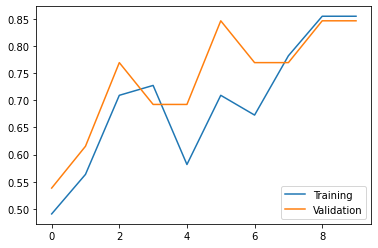

In [199]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

(224, 224, 3)


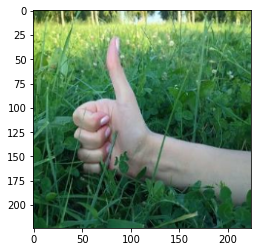

[[0.06067116 0.15341249 0.04402342 0.74189293]]
thumbs_up


In [222]:
i = 2
print(image_batch[i].shape)
plt.imshow(image_batch[i].numpy().astype('uint8'))
plt.show()

test = tf.expand_dims(image_batch[i], axis=0)
oh = my_model.predict(test)
print(oh)
print(class_names[tf.argmax(oh[0])])
